-- version history --

<br>--- v1 ---
> - use only event timeline info to create nodes and edges
> - multiple edges rolled in-to 1 and not learning the importance of weights
> - embedding based similarity matrix and confusion matrix generated for comparing against the 46 data points
----------


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
%matplotlib inline

In [4]:
df_eeseq = pd.read_csv('./data/20220509/eventsequence_all/part-00000-e4d812f1-8e12-48a2-a969-cbb0ca5d20ac-c000.csv',sep="\t")
df_eeseq.shape

(130613, 15)

In [5]:
print(list(df_eeseq.columns))

['site_id', 'event_node_name_p1', 'mac_new', 'event_sequence', 'event_node_name', 'event_node_name_to', 'start_time', 'end_time', 'start_time_next', 'end_time_next', 'time_delta_seconds', 'start_time_utc', 'end_time_utc', 'start_time_next_utc', 'end_time_next_utc']


In [8]:
df_eeseq.sample(3)

,site_id,event_node_name_p1,mac_new,event_sequence,event_node_name,event_node_name_to,start_time,end_time,start_time_next,end_time_next,time_delta_seconds,start_time_utc,end_time_utc,start_time_next_utc,end_time_next_utc
125305,eddd0a96-c390-4fe8-a632-36603a9936a6,0038&87,fc9643cf3dc1,38,87,54.0,1652110991000,1652114411000,1.652113e+12,1.652125e+12,2049.853,2022-05-09 15:43:11,2022-05-09 16:40:11,2022-05-09 16:17:20,2022-05-09 19:43:58
49757,6cf57059-af1c-4bac-a2cc-524144e3d5fc,0129&87,b033a6748b84,129,87,42.0,1652055857000,1652056037000,1.652056e+12,1.652056e+12,7.000,2022-05-09 00:24:17,2022-05-09 00:27:17,2022-05-09 00:24:24,2022-05-09 00:24:24
5685,0a6fe7e6-30c5-48b9-8547-a6fc09b1c6b7,0011&87,1039e974ae1e,11,87,87.0,1652115453000,1652115633000,1.652130e+12,1.652130e+12,14756.000,2022-05-09 16:57:33,2022-05-09 17:00:33,2022-05-09 21:03:29,2022-05-09 21:06:29


In [10]:
df_eeseq_snip = df_eeseq.groupby(['event_node_name', 'event_node_name_to'])['event_node_name_p1'].agg(len).reset_index()

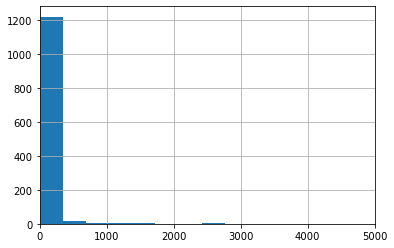

In [16]:
df_eeseq_snip.event_node_name_p1.hist(bins=100); plt.xlim([0, 5000]);plt.show()

In [17]:
df_eeseq_snip.shape

(1252, 3)

In [18]:
df_eeseq_snip.event_node_name_p1.sum()

128361

In [19]:
df_eeseq_snip.sample(3)

,event_node_name,event_node_name_to,event_node_name_p1
169,17,34.0,1
1234,89,68.0,5
483,38,77.0,6


In [23]:
df_eeseq_snip.event_node_name_to = df_eeseq_snip.event_node_name_to.astype(np.int32)
df_eeseq_snip.sample(3)

,event_node_name,event_node_name_to,event_node_name_p1
491,39,52,2
694,55,89,18
202,20,89,3


In [25]:
df_eeseq_snip.to_csv('./data/20220509/editedsamples/eeseq.csv')

In [27]:
df_eedict = pd.read_csv('./data/20220509/events_dict_all/part-00000-eb219c1b-f555-45ea-9dd9-6faa4dab5f12-c000.csv',sep = '\t')
df_eedict.shape

(90, 6)

In [28]:
df_eedict.head(3)

,display_entity_type,entity_type,event_name,event_type,node_id,event_node_name
0,ap,ap,ap_disconnect,boot_configuration_broke_the_cloud,0,ap|ap|ap_disconnect|boot_configuration_broke_t...
1,ap,ap,ap_disconnect,boot_configuration_invalid,1,ap|ap|ap_disconnect|boot_configuration_invalid
2,ap,ap,ap_disconnect,cloud_cert_time_check_failure,2,ap|ap|ap_disconnect|cloud_cert_time_check_failure


In [29]:
df_eedict[['node_id','event_node_name']].to_csv('./data/20220509/editedsamples/eedict.csv')

### Construct graph in PyG format

In [6]:
import torch

In [7]:
def load_node_csv(path, index_col, encoders=None, **kwargs):
    df = pd.read_csv(path, index_col=index_col, **kwargs)
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

In [8]:
eedict_path = "./data/20220509/editedsamples/eedict.csv"
_, ee_mapping = load_node_csv(eedict_path, index_col='node_id') # create a node-id for pyg internals from the node information file

In [9]:
type(ee_mapping)

dict

In [10]:
ee_mapping.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89])

In [11]:
ee_mapping[1], ee_mapping[89]

(1, 89)

In [12]:
from torch_geometric.data import HeteroData

In [27]:
data = HeteroData()

data['entity_event'].num_nodes = len(ee_mapping)  # entity event nodes do not have any features.
print(data)

HeteroData(
  entity_event={ num_nodes=90 }
)


In [28]:
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping,
                  encoders=None, **kwargs):
    df = pd.read_csv(path, **kwargs)

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [29]:
class IdentityEncoder(object):
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(df.values).view(-1, 1).to(self.dtype)
    
#  for loading the ratings from the rating column in ratings.csv, we can define an IdentityEncoder 
# that simply converts a list of floating-point values into a PyTorch tensor

In [30]:
ee_edgespath = './data/20220509/editedsamples/eeseq.csv'

edge_index, edge_label = load_edge_csv(
    ee_edgespath,
    src_index_col='event_node_name',
    src_mapping=ee_mapping,
    dst_index_col='event_node_name_to',
    dst_mapping=ee_mapping,
    encoders={'event_node_name_p1': IdentityEncoder(dtype=torch.long)},
)

In [31]:
data['entity_event', 'followed_by', 'entity_event'].edge_index = edge_index
data['entity_event', 'followed_by', 'entity_event'].edge_label = edge_label

print(data)
# HeteroData(
#   user={ num_nodes=610 },
#   movie={ x=[9742, 404] },
#   (user, rates, movie)={
#     edge_index=[2, 100836],
#     edge_label=[100836, 1]
#   }
# )

HeteroData(
  entity_event={ num_nodes=90 },
  (entity_event, followed_by, entity_event)={
    edge_index=[2, 1252],
    edge_label=[1252, 1]
  }
)


In [32]:
# We can now convert `data` into an appropriate format for training a
# graph-based machine learning model:

In [33]:
from torch_geometric.transforms import RandomLinkSplit, ToUndirected

In [34]:
# 1. Add a reverse ('movie', 'rev_rates', 'user') relation for message passing.
data = ToUndirected()(data)

In [35]:
print(data)

HeteroData(
  entity_event={ num_nodes=90 },
  (entity_event, followed_by, entity_event)={
    edge_index=[2, 1568],
    edge_label=[1568, 1]
  }
)


In [36]:
data.edge_types

[('entity_event', 'followed_by', 'entity_event')]

In [37]:
data.metadata()

(['entity_event'], [('entity_event', 'followed_by', 'entity_event')])

In [24]:
# del data['entity_event', 'rev_followed_by', 'entity_event'].edge_label

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
# add one-hot encoding vector for user nodes
# Add user node features for message passing:
data['entity_event'].x = torch.eye(data['entity_event'].num_nodes, device=device)
del data['entity_event'].num_nodes
print(data)

HeteroData(
  entity_event={ x=[90, 90] },
  (entity_event, followed_by, entity_event)={
    edge_index=[2, 1568],
    edge_label=[1568, 1]
  }
)


In [39]:
# del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# 2. Perform a link-level split into training, validation, and test edges.
transform = RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('entity_event', 'followed_by', 'entity_event')],
    rev_edge_types=[None],
)
train_data, val_data, test_data = transform(data)
print(train_data)
print(val_data)
print(test_data)

HeteroData(
  entity_event={ x=[90, 90] },
  (entity_event, followed_by, entity_event)={
    edge_index=[2, 1334],
    edge_label=[1334, 1],
    edge_label_index=[2, 1334]
  }
)
HeteroData(
  entity_event={ x=[90, 90] },
  (entity_event, followed_by, entity_event)={
    edge_index=[2, 1334],
    edge_label=[78, 1],
    edge_label_index=[2, 78]
  }
)
HeteroData(
  entity_event={ x=[90, 90] },
  (entity_event, followed_by, entity_event)={
    edge_index=[2, 1412],
    edge_label=[156, 1],
    edge_label_index=[2, 156]
  }
)


In [40]:
type(data)

torch_geometric.data.hetero_data.HeteroData

#### run graphsage

In [41]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression

import torch_geometric.transforms as T
from torch_geometric.loader import NeighborSampler as RawNeighborSampler
from torch_geometric.nn import SAGEConv

In [42]:
from torch_cluster import random_walk

In [43]:
class NeighborSampler(RawNeighborSampler):
    def sample(self, batch):
        batch = torch.tensor(batch)
        row, col, _ = self.adj_t.coo()

        # For each node in `batch`, we sample a direct neighbor (as positive
        # example) and a random node (as negative example):
        pos_batch = random_walk(row, col, batch, walk_length=1,
                                coalesced=False)[:, 1]

        neg_batch = torch.randint(0, self.adj_t.size(1), (batch.numel(), ),
                                  dtype=torch.long)

        batch = torch.cat([batch, pos_batch, neg_batch], dim=0)
        return super().sample(batch)


In [44]:
train_data_homo = train_data.to_homogeneous()
print(train_data_homo)

Data(node_type=[90], x=[90, 90], edge_index=[2, 1334], edge_type=[1334], edge_label=[1334, 1], edge_label_index=[2, 1334])


In [45]:
train_loader = NeighborSampler(train_data_homo.edge_index, sizes=[10, 10], batch_size=256,
                               shuffle=True, num_nodes=train_data_homo.num_nodes)

In [46]:
val_data_homo = val_data.to_homogeneous()
print(val_data_homo)

Data(node_type=[90], x=[90, 90], edge_index=[2, 1334], edge_type=[1334], edge_label=[78, 1], edge_label_index=[2, 78])


In [47]:
val_loader = NeighborSampler(val_data_homo.edge_index, sizes=[10, 10], batch_size=256,
                               shuffle=True, num_nodes=val_data_homo.num_nodes)

In [48]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [50]:
train_data_homo.num_node_features

90

In [51]:
def train():
    model.train()

    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()

        out = model(x[n_id], adjs)
        out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

        pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
        neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
        loss = -pos_loss - neg_loss
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * out.size(0)

    return total_loss / train_data_homo.num_nodes




In [52]:
@torch.no_grad()
def test():
    model.eval()
    total_loss = 0
    for batch_size, n_id, adjs in val_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
#         optimizer.zero_grad()

        out = model(x_val[n_id], adjs)
        out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

        pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
        neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
        loss = -pos_loss - neg_loss
#         loss.backward()
#         optimizer.step()

        total_loss += float(loss) * out.size(0)

    return total_loss / val_data_homo.num_nodes

In [114]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(train_data_homo.num_node_features, hidden_channels=64, num_layers=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=0.9)
x, edge_index = train_data_homo.x.to(device), train_data_homo.edge_index.to(device)

In [115]:
x_val, edge_index_val = val_data_homo.x.to(device), val_data_homo.edge_index.to(device)

In [116]:
history=list()

for epoch in range(1, 500):
    loss = train()
    val_loss = test()
    history.append([loss, val_loss])
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, 'f'Val: {val_loss:.4f}')

Epoch: 001, Loss: 1.4486, Val: 1.4444
Epoch: 002, Loss: 1.4405, Val: 1.4458
Epoch: 003, Loss: 1.4491, Val: 1.4501
Epoch: 004, Loss: 1.4526, Val: 1.4462
Epoch: 005, Loss: 1.4484, Val: 1.4480
Epoch: 006, Loss: 1.4435, Val: 1.4460
Epoch: 007, Loss: 1.4395, Val: 1.4495
Epoch: 008, Loss: 1.4449, Val: 1.4434
Epoch: 009, Loss: 1.4481, Val: 1.4443
Epoch: 010, Loss: 1.4389, Val: 1.4460
Epoch: 011, Loss: 1.4438, Val: 1.4448
Epoch: 012, Loss: 1.4569, Val: 1.4403
Epoch: 013, Loss: 1.4349, Val: 1.4404
Epoch: 014, Loss: 1.4417, Val: 1.4425
Epoch: 015, Loss: 1.4451, Val: 1.4408
Epoch: 016, Loss: 1.4398, Val: 1.4381
Epoch: 017, Loss: 1.4400, Val: 1.4405
Epoch: 018, Loss: 1.4443, Val: 1.4428
Epoch: 019, Loss: 1.4434, Val: 1.4422
Epoch: 020, Loss: 1.4364, Val: 1.4411
Epoch: 021, Loss: 1.4388, Val: 1.4353
Epoch: 022, Loss: 1.4367, Val: 1.4369
Epoch: 023, Loss: 1.4427, Val: 1.4351
Epoch: 024, Loss: 1.4413, Val: 1.4345
Epoch: 025, Loss: 1.4326, Val: 1.4333
Epoch: 026, Loss: 1.4371, Val: 1.4348
Epoch: 027, 

Epoch: 229, Loss: 1.4007, Val: 1.3989
Epoch: 230, Loss: 1.3995, Val: 1.3983
Epoch: 231, Loss: 1.3974, Val: 1.3995
Epoch: 232, Loss: 1.3998, Val: 1.3992
Epoch: 233, Loss: 1.3968, Val: 1.3979
Epoch: 234, Loss: 1.4006, Val: 1.3987
Epoch: 235, Loss: 1.3996, Val: 1.3985
Epoch: 236, Loss: 1.3998, Val: 1.3983
Epoch: 237, Loss: 1.4004, Val: 1.3987
Epoch: 238, Loss: 1.4017, Val: 1.3983
Epoch: 239, Loss: 1.3971, Val: 1.3983
Epoch: 240, Loss: 1.4003, Val: 1.3981
Epoch: 241, Loss: 1.3977, Val: 1.3980
Epoch: 242, Loss: 1.3990, Val: 1.3974
Epoch: 243, Loss: 1.4021, Val: 1.3985
Epoch: 244, Loss: 1.3965, Val: 1.3979
Epoch: 245, Loss: 1.3989, Val: 1.3988
Epoch: 246, Loss: 1.3948, Val: 1.3982
Epoch: 247, Loss: 1.3978, Val: 1.3974
Epoch: 248, Loss: 1.3978, Val: 1.3983
Epoch: 249, Loss: 1.3977, Val: 1.3975
Epoch: 250, Loss: 1.3990, Val: 1.3964
Epoch: 251, Loss: 1.3990, Val: 1.3988
Epoch: 252, Loss: 1.3982, Val: 1.3974
Epoch: 253, Loss: 1.3982, Val: 1.3967
Epoch: 254, Loss: 1.3970, Val: 1.3982
Epoch: 255, 

Epoch: 453, Loss: 1.3903, Val: 1.3901
Epoch: 454, Loss: 1.3904, Val: 1.3902
Epoch: 455, Loss: 1.3899, Val: 1.3896
Epoch: 456, Loss: 1.3899, Val: 1.3898
Epoch: 457, Loss: 1.3892, Val: 1.3899
Epoch: 458, Loss: 1.3905, Val: 1.3900
Epoch: 459, Loss: 1.3911, Val: 1.3902
Epoch: 460, Loss: 1.3898, Val: 1.3899
Epoch: 461, Loss: 1.3904, Val: 1.3898
Epoch: 462, Loss: 1.3903, Val: 1.3897
Epoch: 463, Loss: 1.3902, Val: 1.3900
Epoch: 464, Loss: 1.3896, Val: 1.3893
Epoch: 465, Loss: 1.3899, Val: 1.3902
Epoch: 466, Loss: 1.3908, Val: 1.3900
Epoch: 467, Loss: 1.3902, Val: 1.3897
Epoch: 468, Loss: 1.3899, Val: 1.3899
Epoch: 469, Loss: 1.3899, Val: 1.3899
Epoch: 470, Loss: 1.3903, Val: 1.3900
Epoch: 471, Loss: 1.3902, Val: 1.3897
Epoch: 472, Loss: 1.3900, Val: 1.3896
Epoch: 473, Loss: 1.3895, Val: 1.3898
Epoch: 474, Loss: 1.3898, Val: 1.3896
Epoch: 475, Loss: 1.3900, Val: 1.3902
Epoch: 476, Loss: 1.3898, Val: 1.3896
Epoch: 477, Loss: 1.3902, Val: 1.3897
Epoch: 478, Loss: 1.3886, Val: 1.3896
Epoch: 479, 

In [117]:
df2plot = pd.DataFrame(history).reset_index()
df2plot.columns=['epoch', 'train_loss', 'validation_loss']

df2plot.head(3)

,epoch,train_loss,validation_loss
0,0,1.448586,1.444442
1,1,1.440490,1.445811
2,2,1.449150,1.450095


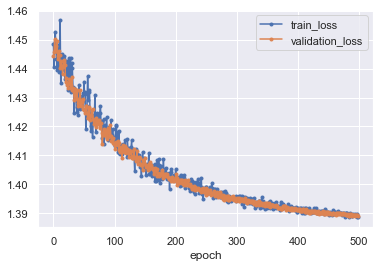

In [118]:
df2plot.plot(x='epoch', y=['train_loss', 'validation_loss'], kind='line', style='.-'); plt.show();
# lr=0.0005,weight_decay=0.1

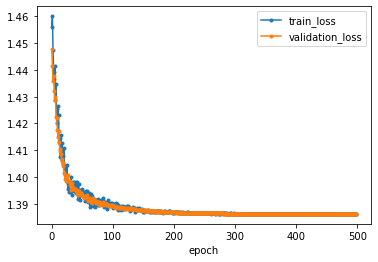

In [91]:
df2plot.plot(x='epoch', y=['train_loss', 'validation_loss'], kind='line', style='.-'); plt.show();
# lr=0.0005,weight_decay=0.1

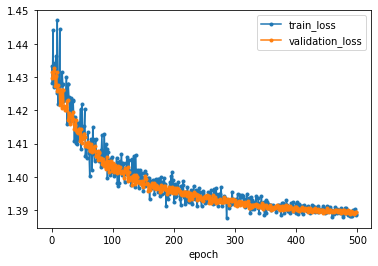

In [62]:
df2plot.plot(x='epoch', y=['train_loss', 'validation_loss'], kind='line', style='.-'); plt.show();
# lr 0.0001, weight-decay = 0.1

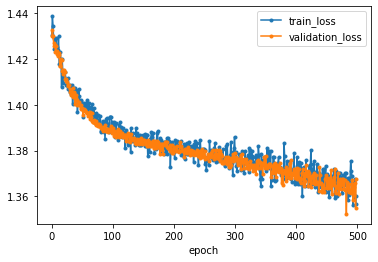

In [56]:
df2plot.plot(x='epoch', y=['train_loss', 'validation_loss'], kind='line', style='.-'); plt.show();
# lr 0.0001, weight-decay = 0

In [164]:
model()

NameError: name 'adjs' is not defined

In [113]:
del model

- get embeddings for the nodes

In [92]:
print(data)

HeteroData(
  entity_event={ x=[90, 90] },
  (entity_event, followed_by, entity_event)={
    edge_index=[2, 1568],
    edge_label=[1568, 1]
  }
)


In [93]:
data_homo = data.to_homogeneous()
print(data_homo)

Data(node_type=[90], x=[90, 90], edge_index=[2, 1568], edge_type=[1568], edge_label=[1568, 1])


In [94]:
data_homo.edge_index.to(device)

tensor([[ 0,  1,  1,  ..., 89, 89, 89],
        [89,  4, 13,  ..., 87, 88, 89]])

In [120]:
model.eval()
out_embs = model.full_forward(data_homo.x.to(device), data_homo.edge_index.to(device))

In [121]:
print(type(out_embs))

<class 'torch.Tensor'>


In [122]:
out_embs.shape

torch.Size([90, 64])

In [123]:
out_embs[0]

tensor([-0.0022, -0.0537,  0.0850,  0.0201,  0.0695,  0.0032,  0.0202,  0.0412,
        -0.0211,  0.0143,  0.0131, -0.0196, -0.0150,  0.0611,  0.0092,  0.0140,
         0.0680,  0.0102, -0.0541,  0.0866,  0.0585, -0.0142,  0.0243,  0.0927,
        -0.0323, -0.0183,  0.0505,  0.0218,  0.0249, -0.0242,  0.0756,  0.0096,
        -0.0749,  0.0187, -0.0299,  0.0319, -0.0048,  0.0231,  0.0228, -0.0004,
         0.0527,  0.0100, -0.0470,  0.0426, -0.0449,  0.0464,  0.0337,  0.0339,
         0.0389,  0.0545,  0.0518,  0.0305,  0.0339, -0.0216,  0.0943, -0.0308,
        -0.0283, -0.0003,  0.0790, -0.0674,  0.0006, -0.0049,  0.0404, -0.0434],
       grad_fn=<SelectBackward0>)

In [124]:
n1 = out_embs.cpu().detach().numpy()
n1.shape

(90, 64)

In [125]:
n1_normed = n1/np.linalg.norm(n1, axis=1,keepdims=True)
n1_normed.shape

(90, 64)

In [126]:
similarity_matrix_normed = np.dot(n1_normed, n1_normed.T)
similarity_matrix_normed.shape

(90, 90)

In [127]:
import seaborn as sns; sns.set_theme()

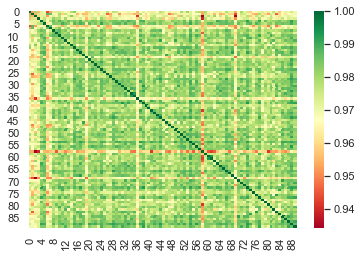

In [128]:
ax = sns.heatmap(similarity_matrix_normed, cmap="RdYlGn")

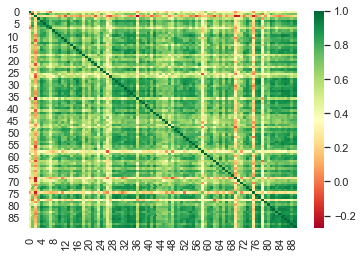

In [189]:
ax = sns.heatmap(similarity_matrix_normed, cmap="RdYlGn")

In [129]:
similarity_matrix_normed[0]

array([1.        , 0.95243335, 0.98004055, 0.9555182 , 0.97268635,
       0.9692756 , 0.94382787, 0.9533748 , 0.9716485 , 0.9608112 ,
       0.9733189 , 0.97139955, 0.9683668 , 0.9637381 , 0.9790702 ,
       0.98218054, 0.9686898 , 0.96650285, 0.9671527 , 0.9575713 ,
       0.97354215, 0.96526337, 0.9730408 , 0.9708573 , 0.9687159 ,
       0.96815175, 0.9771171 , 0.96451443, 0.9769447 , 0.9762987 ,
       0.9694811 , 0.9676815 , 0.9687368 , 0.97108555, 0.9658008 ,
       0.96770203, 0.9555855 , 0.96683216, 0.97295326, 0.9681907 ,
       0.9710017 , 0.96222675, 0.97095907, 0.9666322 , 0.9777418 ,
       0.97410405, 0.9663717 , 0.97132975, 0.9683798 , 0.9643041 ,
       0.96677715, 0.97946626, 0.9723995 , 0.9807199 , 0.9723276 ,
       0.96646357, 0.9760974 , 0.97847944, 0.95441985, 0.9789539 ,
       0.9693176 , 0.96661615, 0.9704599 , 0.9625575 , 0.9718752 ,
       0.96905804, 0.978559  , 0.9719997 , 0.97207206, 0.95363885,
       0.9675591 , 0.97988176, 0.97096896, 0.9746215 , 0.95843

In [132]:
np.linalg.norm(similarity_matrix_normed[0])

9.1963825

In [130]:
similarity_matrix_normed.max(), similarity_matrix_normed.min()

(1.0000004, 0.934164)

<h5>Write out pair scores

In [151]:
pairwise_relation = list()

# for i in range(similarity_matrix_normed.shape[0]):
#     for j in range(similarity_matrix_normed.shape[1]):
#         if i<=j:
#             pairwise_relation.append([i, j, similarity_matrix_normed[i][j]])
#         else:
#             continue
# print(len(pairwise_relation))


for i in range(similarity_matrix_normed.shape[0]):
    for j in range(similarity_matrix_normed.shape[1]):
        pairwise_relation.append([i, j, similarity_matrix_normed[i][j]])

print(len(pairwise_relation))

8100


In [152]:
dfout1 = pd.DataFrame(pairwise_relation,columns=['from','to','similarity_normed'])
dfout1.head(3)

,from,to,similarity_normed
0,0,0,1.000000
1,0,1,0.952433
2,0,2,0.980041


In [153]:
event_dict = pd.read_csv('./data/20220509/events_dict_all/part-00000-eb219c1b-f555-45ea-9dd9-6faa4dab5f12-c000.csv', sep="\t")
event_dict.head(3)

,display_entity_type,entity_type,event_name,event_type,node_id,event_node_name
0,ap,ap,ap_disconnect,boot_configuration_broke_the_cloud,0,ap|ap|ap_disconnect|boot_configuration_broke_t...
1,ap,ap,ap_disconnect,boot_configuration_invalid,1,ap|ap|ap_disconnect|boot_configuration_invalid
2,ap,ap,ap_disconnect,cloud_cert_time_check_failure,2,ap|ap|ap_disconnect|cloud_cert_time_check_failure


In [154]:
dfout2 = dfout1.merge(event_dict[['node_id','event_node_name']], left_on='from', right_on='node_id')\
                .merge(event_dict[['node_id','event_node_name']], left_on='to', right_on='node_id', suffixes=('_from', '_to'))

dfout2.head(3)

,from,to,similarity_normed,node_id_from,event_node_name_from,node_id_to,event_node_name_to
0,0,0,1.000000,0,ap|ap|ap_disconnect|boot_configuration_broke_t...,0,ap|ap|ap_disconnect|boot_configuration_broke_t...
1,1,0,0.952433,1,ap|ap|ap_disconnect|boot_configuration_invalid,0,ap|ap|ap_disconnect|boot_configuration_broke_t...
2,2,0,0.980041,2,ap|ap|ap_disconnect|cloud_cert_time_check_failure,0,ap|ap|ap_disconnect|boot_configuration_broke_t...


In [155]:
dfout2['matchcol'] = dfout2['event_node_name_from']+ "_" + dfout2['event_node_name_to']

In [156]:
dfout2.head(3)

,from,to,similarity_normed,node_id_from,event_node_name_from,node_id_to,event_node_name_to,matchcol
0,0,0,1.000000,0,ap|ap|ap_disconnect|boot_configuration_broke_t...,0,ap|ap|ap_disconnect|boot_configuration_broke_t...,ap|ap|ap_disconnect|boot_configuration_broke_t...
1,1,0,0.952433,1,ap|ap|ap_disconnect|boot_configuration_invalid,0,ap|ap|ap_disconnect|boot_configuration_broke_t...,ap|ap|ap_disconnect|boot_configuration_invalid...
2,2,0,0.980041,2,ap|ap|ap_disconnect|cloud_cert_time_check_failure,0,ap|ap|ap_disconnect|boot_configuration_broke_t...,ap|ap|ap_disconnect|cloud_cert_time_check_fail...


In [146]:
df_groundtruth = pd.read_csv('./data/groundtruth_v01.txt', sep="\t")
df_groundtruth.sample(3)

,event_name_1,event_name_2,Possible [y/n],Confidence [H/M/L],Comments,Already known [Y/N],Impact [H/L]
30,switch|switch|config_failure|commit_check,switch|switch|switch_health|fan_alarm,N,NaN,NaN,NaN,NaN
10,switch|switch|switch_disconnect|switch_disconnect,switch|switch|config_failure|load_config_error,y,NaN,what inside the config is impacting will be us...,NaN,H
6,switch|switch_interface|switch_port_flap|switc...,client|client|bad_client|client_auth_failure,N,NaN,interesting,NaN,NaN


In [149]:
df_groundtruth['matchcol'] = df_groundtruth['event_name_1']+"_"+df_groundtruth['event_name_2']
df_groundtruth.head(3)

,event_name_1,event_name_2,Possible [y/n],Confidence [H/M/L],Comments,Already known [Y/N],Impact [H/L],matchcol
0,switch|switch_interface|switch_port_flap|switc...,ap|ap|low_memory|kernel_low_memory,N,NaN,NaN,NaN,NaN,switch|switch_interface|switch_port_flap|switc...
1,switch|switch_interface|switch_port_flap|switc...,client|client|bad_client|wired_client_auth_fai...,Y,NaN,interesting; event2 --> event 1,y,NaN,switch|switch_interface|switch_port_flap|switc...
2,switch|switch_interface|switch_port_flap|switc...,ap|ap|ap_restart|pace_fatal,N,h,NaN,NaN,NaN,switch|switch_interface|switch_port_flap|switc...


In [157]:
dfout3 = dfout2.merge(df_groundtruth, on ='matchcol', how='inner')
dfout3.shape

(37, 15)

In [158]:
dfout3.head(3)

,from,to,similarity_normed,node_id_from,event_node_name_from,node_id_to,event_node_name_to,matchcol,event_name_1,event_name_2,Possible [y/n],Confidence [H/M/L],Comments,Already known [Y/N],Impact [H/L]
0,4,5,0.980202,4,ap|ap|ap_disconnect|locally_offline,5,ap|ap|ap_disconnect|locally_online,ap|ap|ap_disconnect|locally_offline_ap|ap|ap_d...,ap|ap|ap_disconnect|locally_offline,ap|ap|ap_disconnect|locally_online,y,NaN,NaN,y,NaN
1,25,5,0.983006,25,ap|ap|bad_cable|bad_cable,5,ap|ap|ap_disconnect|locally_online,ap|ap|bad_cable|bad_cable_ap|ap|ap_disconnect|...,ap|ap|bad_cable|bad_cable,ap|ap|ap_disconnect|locally_online,y,NaN,get eamples on these one,NaN,NaN
2,4,6,0.967475,4,ap|ap|ap_disconnect|locally_offline,6,ap|ap|ap_disconnect|mutual_authentication_failed,ap|ap|ap_disconnect|locally_offline_ap|ap|ap_d...,ap|ap|ap_disconnect|locally_offline,ap|ap|ap_disconnect|mutual_authentication_failed,y,NaN,NaN,y,NaN


In [166]:
threshold=0.97
dfout3['pred'] = dfout3['similarity_normed']>threshold

dfout3['truth'] = dfout3['Possible [y/n]']!="N"

In [167]:
selcols1 = ['event_node_name_from', 'event_node_name_to', 'pred', 'truth']

dfout3[selcols1].head(3)

,event_node_name_from,event_node_name_to,pred,truth
0,ap|ap|ap_disconnect|locally_offline,ap|ap|ap_disconnect|locally_online,True,True
1,ap|ap|bad_cable|bad_cable,ap|ap|ap_disconnect|locally_online,True,True
2,ap|ap|ap_disconnect|locally_offline,ap|ap|ap_disconnect|mutual_authentication_failed,False,True


In [168]:
dfout3.truth.value_counts()

True     27
False    10
Name: truth, dtype: int64

In [169]:
from sklearn.metrics import confusion_matrix

In [172]:
a = confusion_matrix(dfout3.truth, dfout3.pred)
a

array([[ 3,  7],
       [ 3, 24]])

In [177]:
accuracy = (a[0][0]+a[1][1])/(a.sum())

print('accuracy is %0.4f' %accuracy)

accuracy is 0.7297


In [175]:
a.sum()

37